# Exploring the traffic accidents dataset

Data used for this notebook represents traffic accidents in Serbia, by police departments (here shown as cities, for simplicity), for year 2022, and it comes from [open data](https://data.gov.rs/sr/datasets/) provided by Republic of Serbia. Imported csv file is not directly from the website mentioned above, it was slightly changed before it was imported here.

The idea is to train models with informations about traffic accidents, such as the time of the accident, type of the accident, etc, and predict the outcome of new traffic accidents based on those informations. There are three different outcomes: 'material damage', 'injured' and 'died', so it is a multiclass classification problem.

## Getting the data

In [1]:
import pandas as pd

df_ta = pd.read_csv('./ta-2022-2023.csv', header=None)
print (f'Number of records: {len(df_ta)}')
df_ta.head()

Number of records: 33399


,0,1
0,BEOGRAD;Zima;01.01.2022,02:30;02;20.430.508;44.580.407;Sa mat.stetom;S...
1,BEOGRAD;Zima;01.01.2022,16:10;16;2.034.629;4.460.398;Sa povredjenim;SN...
2,BEOGRAD;Zima;06.01.2022,12:10;12;20.414.231;44.577.657;Sa mat.stetom;S...
3,BEOGRAD;Zima;06.01.2022,11:00;11;2.039.882;4.460.251;Sa mat.stetom;SN ...
4,BEOGRAD;Zima;08.01.2022,20:15;20;20.344.523;44.602.351;Sa mat.stetom;S...


This dataset doesn't look good, so before doing anything else we need to make some changes.

## Editing DataFrame

In [2]:
# Extracting useful data and disregarding useless data
df_ta[2] = df_ta[0].apply(lambda x: x.split(";", 1)[0])
df_ta[3] = df_ta[0].apply(lambda x: x.split(";", 2)[1])
df_ta[4] = df_ta[1].apply(lambda x: int(x.split(";", 2)[1]))
df_ta[5] = df_ta[1].apply(lambda x: x.split(";", 5)[4])
df_ta[6] = df_ta[1].apply(lambda x: x.split(";", 5)[5])

df_ta = df_ta.drop([0, 1], axis=1)

df_ta.columns = ['City', 'Season', 'Hour', 'Outcome', 'Type']
df_ta.head()

,City,Season,Hour,Outcome,Type
0,BEOGRAD,Zima,2,Sa mat.stetom,SN SA JEDNIM VOZILOM
1,BEOGRAD,Zima,16,Sa povredjenim,SN SA PARKIRANIM VOZILIMA
2,BEOGRAD,Zima,12,Sa mat.stetom,SN SA PARKIRANIM VOZILIMA
3,BEOGRAD,Zima,11,Sa mat.stetom,SN SA JEDNIM VOZILOM
4,BEOGRAD,Zima,20,Sa mat.stetom,SN SA PARKIRANIM VOZILIMA


Now the DataFrame already looks much better. Next main thing is to replace text values with numerical.

In [3]:
import numpy as np

# Mapping numerical values to class labels
class_mapping = {label: idx for idx, label in enumerate(np.unique(df_ta['Outcome']))}
df_ta['Outcome'] = df_ta['Outcome'].map(class_mapping)
print(class_mapping)
df_ta.head()

{'Sa mat.stetom': 0, 'Sa poginulim': 1, 'Sa povredjenim': 2}


,City,Season,Hour,Outcome,Type
0,BEOGRAD,Zima,2,0,SN SA JEDNIM VOZILOM
1,BEOGRAD,Zima,16,2,SN SA PARKIRANIM VOZILIMA
2,BEOGRAD,Zima,12,0,SN SA PARKIRANIM VOZILIMA
3,BEOGRAD,Zima,11,0,SN SA JEDNIM VOZILOM
4,BEOGRAD,Zima,20,0,SN SA PARKIRANIM VOZILIMA


In [4]:
# Performing one-hot encoding for season and type 
df_ta = pd.get_dummies(df_ta, prefix=['Season', 'Type'], columns=['Season', 'Type'], drop_first=True)
# Renaming columns
df_ta.rename(columns={'Season_Leto': 'Season_Summer', 'Season_Prolece': 'Season_Spring', 'Season_Zima': 'Season_Winter', 'Type_SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA': 'Type_At least two vehicles - no turning', 'Type_SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK': 'Type_At least two vehicles - turning', 'Type_SN SA PARKIRANIM VOZILIMA': 'Type_With parked vehicle', 'Type_SN SA PEŠACIMA': 'Type_With pedestrian'}, inplace=True)
# Reordering columns
df_ta = df_ta[['City', 'Hour', 'Season_Summer', 'Season_Spring', 'Season_Winter', 'Type_At least two vehicles - no turning', 'Type_At least two vehicles - turning', 'Type_With parked vehicle', 'Type_With pedestrian', 'Outcome']]
df_ta.head()

,City,Hour,Season_Summer,Season_Spring,Season_Winter,Type_At least two vehicles - no turning,Type_At least two vehicles - turning,Type_With parked vehicle,Type_With pedestrian,Outcome
0,BEOGRAD,2,0,0,1,0,0,0,0,0
1,BEOGRAD,16,0,0,1,0,0,1,0,2
2,BEOGRAD,12,0,0,1,0,0,1,0,0
3,BEOGRAD,11,0,0,1,0,0,0,0,0
4,BEOGRAD,20,0,0,1,0,0,1,0,0


Let's check the ratio between the different class labels (traffic accident outcomes).

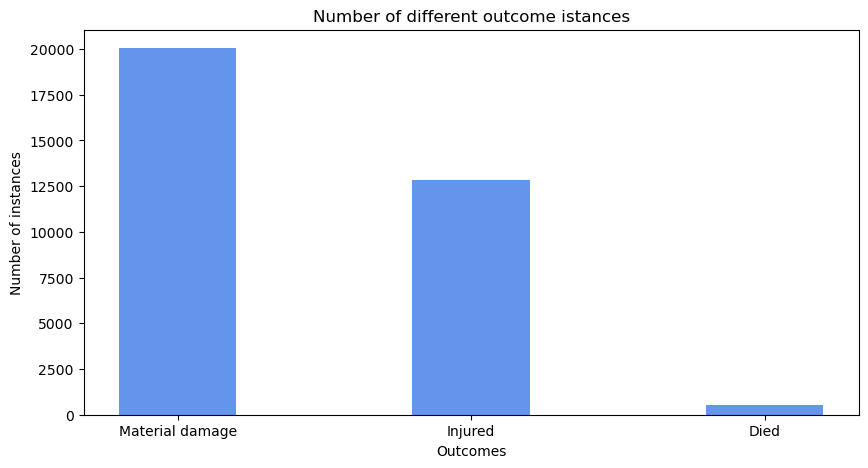

In [5]:
import matplotlib.pyplot as plt

outcomes, counts = np.unique(df_ta['Outcome'], return_counts=True)
outcomes = ['Material damage', 'Injured', 'Died']
counts = sorted(counts, reverse=True)

fig = plt.figure(figsize = (10, 5))
 
# Creating the bar plot
plt.bar(outcomes, counts, color ='cornflowerblue',
        width = 0.4)
 
plt.xlabel("Outcomes")
plt.ylabel("Number of instances")
plt.title("Number of different outcome istances")
plt.show()

As we can see, outcome is 'material damage' in most cases. There are a lot of 'injured' outcomes as well, but there is significantly less 'died' outcomes, luckily.

Next, we can check the ratio between the different cities where the traffic accidents happened. Let's create a bar chart consisted of the six cities with the most traffic accidents.

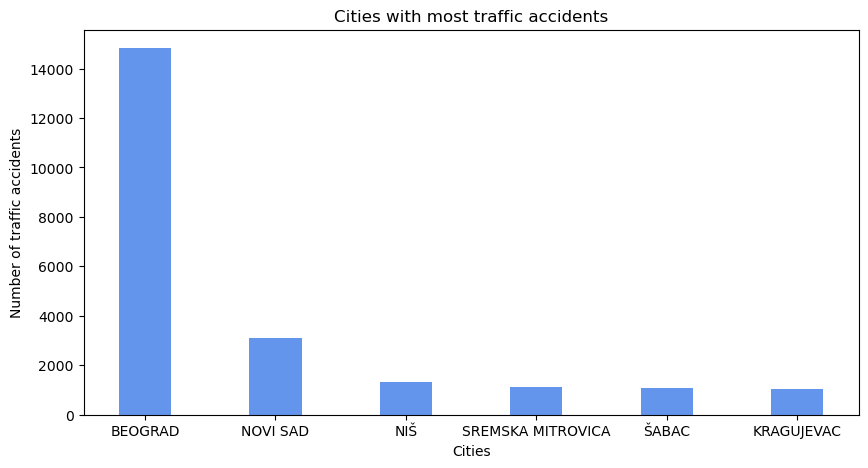

In [6]:
# Finding six cities with most traffic accidents
cities, counts = np.unique(df_ta['City'], return_counts=True)
cities_dict = dict(zip(cities, counts))
sorted_cities = dict(sorted(cities_dict.items(), key=lambda x:x[1], reverse=True))
cities_top_six = list(sorted_cities.keys())[:6]
counts_top_six = list(sorted_cities.values())[:6]

fig = plt.figure(figsize = (10, 5))
 
# Creating the bar plot
plt.bar(cities_top_six, counts_top_six, color ='cornflowerblue',
        width = 0.4)

plt.xlabel("Cities")
plt.ylabel("Number of traffic accidents")
plt.title("Cities with most traffic accidents")
plt.show()

There are definitely the most cases of traffic accidents in Belgrade, while rest of the cities are relatively close to each other.

City column is still not numerical, we need to change that, but since there are a lof of different cities we wont go with one-hot encoder. We will use the count encoder from the category_encoders library. With this type of encoder we will change the city names with number of occurencies of that particular city.

In [7]:
import category_encoders as ce

cities = df_ta[['City']].values
# Using count encoder for replacing the names of the cities with the city counts
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(cities)
df_ta['City'] = count_encoded
df_ta.head()

,City,Hour,Season_Summer,Season_Spring,Season_Winter,Type_At least two vehicles - no turning,Type_At least two vehicles - turning,Type_With parked vehicle,Type_With pedestrian,Outcome
0,14830,2,0,0,1,0,0,0,0,0
1,14830,16,0,0,1,0,0,1,0,2
2,14830,12,0,0,1,0,0,1,0,0
3,14830,11,0,0,1,0,0,0,0,0
4,14830,20,0,0,1,0,0,1,0,0


We are done with the DataFrame editing, now we can partition the dataset into a separate training and test set.

## Splitting the data

In [8]:
from sklearn.model_selection import train_test_split

X, y = df_ta.iloc[:, :-1].values, df_ta.iloc[:, -1:].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=y)

## Bringing features onto the same scale

Scaling the attributes is very important step because most of the ML algorithms perform better if all attributes are in the same scale. Here we will use the standardisation approach.

In [9]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Fitting and evaluating the model

In [10]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train.ravel())

training_acc_lr = round(lr.score(X_train_std, y_train) * 100, 2)
test_acc_lr = round(lr.score(X_test_std, y_test) * 100, 2)

print('Training accuracy:', training_acc_lr)
print('Test accuracy:', test_acc_lr)

Training accuracy: 69.62
Test accuracy: 70.36


In [11]:
# Support Vector Machines

from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=1)
svm.fit(X_train_std, y_train.ravel())

training_acc_svm = round(svm.score(X_train_std, y_train) * 100, 2)
test_acc_svm = round(svm.score(X_test_std, y_test) * 100, 2)

print('Training accuracy:', training_acc_svm)
print('Test accuracy:', test_acc_svm)

Training accuracy: 69.67
Test accuracy: 70.5


In [12]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=10,
                                    random_state=1)
tree_model.fit(X_train, y_train.ravel())

training_acc_dt = round(tree_model.score(X_train, y_train) * 100, 2)
test_acc_dt = round(tree_model.score(X_test, y_test) * 100, 2)

print('Training accuracy:', training_acc_dt)
print('Test accuracy:', test_acc_dt)

Training accuracy: 71.62
Test accuracy: 70.81


In [21]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=20, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train.ravel())

training_acc_rf = round(forest.score(X_train, y_train) * 100, 2)
test_acc_rf = round(forest.score(X_test, y_test) * 100, 2)

print('Training accuracy:', training_acc_rf)
print('Test accuracy:', test_acc_rf)

Training accuracy: 80.02
Test accuracy: 68.42


In [14]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6, 
                           p=1, 
                           metric='minkowski')
knn.fit(X_train_std, y_train.ravel())

training_acc_knn = round(knn.score(X_train_std, y_train) * 100, 2)
test_acc_knn = round(knn.score(X_test_std, y_test) * 100, 2)

print('Training accuracy:', training_acc_knn)
print('Test accuracy:', test_acc_knn)

Training accuracy: 74.13
Test accuracy: 68.72


We trained five different models, in which we used: logistic regression, support vector machines, decision tree, random forest and k-nearest neighbors. We were checking both training and test set accuracy to see if there are any signs of overfitting (indicator of overfitting would be much better score in training set compared to test set) and it seems like we didn't have any problems with that, but we definitely didn't get great score in any of these models (slightly over 70 at best). Although decision tree model performed the best, they were all really close to each other. Let's see final results in a table.

In [15]:
# Model evaluation

models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Decision Tree', 'Random Forest', 'KNN'],
    'Score': [test_acc_lr, test_acc_svm, test_acc_dt, 
              test_acc_rf, test_acc_knn]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,70.81
1,Support Vector Machines,70.50
0,Logistic Regression,70.36
4,KNN,68.72
3,Random Forest,68.42
